<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Zonal-wind" data-toc-modified-id="Zonal-wind-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Zonal wind</a></span><ul class="toc-item"><li><span><a href="#Tropopause" data-toc-modified-id="Tropopause-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tropopause</a></span></li></ul></li><li><span><a href="#Figure-S4" data-toc-modified-id="Figure-S4-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure S4</a></span></li></ul></div>

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import shapely.geometry as sgeom
#import cartopy.crs as ccrs
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from palettable.scientific.diverging import Berlin_20
import numpy as np
import matplotlib as mpl
import glob
#%matplotlib inline

In [2]:
%reload_ext watermark
%watermark --iversions -v -m

xarray     0.16.2
numpy      1.17.3
matplotlib 3.1.2
CPython 3.6.9
IPython 7.16.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-122-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [9]:
DJF_bool = '_DJFonly'
root_path = '/mnt/nas4.meop2/meop40.data.model/CMAM/0A.daily/'
cesta = f'{root_path}composites_woSSW{DJF_bool}/'

# Zonal wind

In [10]:
timescale = 20
var = 'ua'
noe = [11,23,37]

e_type = 'himalayas'
qbo_type_ls = ['QBOE/', 'QBOW/', '']
if var == 'vmro3':
    what_ls = ['percentages', 'absolute']
else:
    what_ls = ['anomalies']
da_ls2 = []

for what in what_ls:
    da_ls = []
    print(what)
    for i,qbo_type in enumerate(qbo_type_ls):
        print(e_type)
        da = xr.open_dataarray('{}{}{}_{}_comp_{}_{}days.nc'.format(cesta, qbo_type, var, what, e_type, timescale))
        if var != 'lwa':
            da['plev'] = da.plev/100.
        else:
            da = da.rename({'z': 'plev'})

        da_ls.append(da)
    da_conc = xr.concat(da_ls, dim = 'qbo_type')
    da_conc['qbo_type'] = ['QBOE','QBOW', 'all']
    da_ls2.append(da_conc)
        
da_all = xr.concat(da_ls2, dim = 'what')
da_all['what'] = what_ls

anomalies
himalayas
himalayas
himalayas


## Tropopause

In [11]:
infile_name = '{}{}_{}_comp_*_{}days.nc'.format(cesta, 'ptrop', 'absolute', 20)
infiles = glob.glob(infile_name)
e_types = list(map(lambda x: x.split('comp_')[1].split('_{}days'.format(timescale))[0], infiles))
da_trop =  xr.open_mfdataset(infiles, concat_dim='e_type', combine='nested')
da_trop['e_type'] = e_types
da_trop['ptrop'] = da_trop.ptrop/100.#da_trop

# Figure S4

ua_anomalies_all_20days_zm_wosignificance_DJFonly_QBO_Himalyasonly.pdf


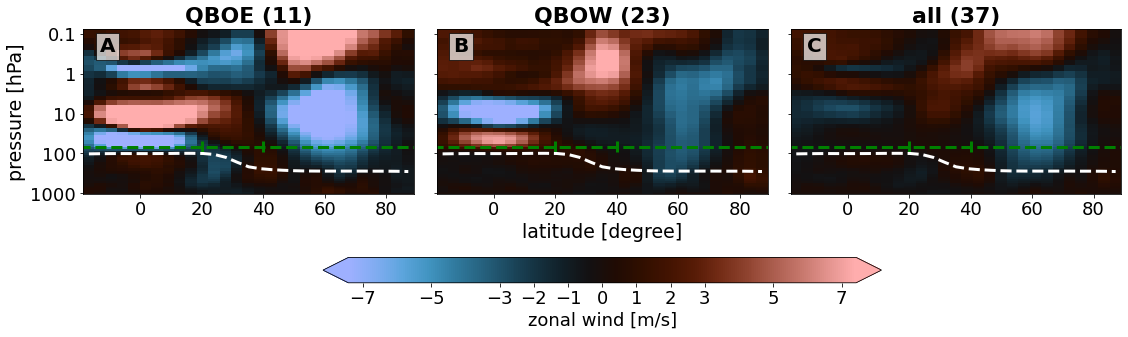

In [12]:
mpl.rcParams.update({'font.size': 18})
ticks = [-7,-5,-3,-2,-1,0,1,2,3,5,7]
clabel = 'zonal wind [m/s]'
cbar_dict = dict(orientation="horizontal", spacing='proportional', extend='both', label = clabel, \
                 fraction=.1,  pad = 0.25, ticks = ticks)

cmap = Berlin_20.mpl_colormap
p = da_all.sel(lag = 0, \
           plev = slice(None, 0.1), \
           lat = slice(-20,None))[0].mean('lon', 
                                          keep_attrs = True).plot(yincrease = False, \
                                                               col = 'qbo_type',cmap = cmap, 
                                                              robust = True, size = 5, 
                                                                          cbar_kwargs=cbar_dict)

label_ls = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
titles = ['QBOE','QBOW','all']
for i, (ax, label) in enumerate(zip(p.axes.flatten(), label_ls)):
    ax.set_title(f'{titles[i]} ({noe[i]})', fontdict=dict(fontweight = 'bold', fontsize = 22))

    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize = 20, 
              fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
    if i == 0:
        ax.set_ylabel('pressure [hPa]', fontdict=dict(fontsize = 19))
        
    if i == 1:
        ax.set_xlabel('latitude [degree]', fontdict=dict(fontsize = 19))
    else:
        ax.set_xlabel('')
    
    ax.hlines(70,-20,90, color = 'green', linestyles='--', linewidths = 3)
    if e_type == 'himalayas':
        box = sgeom.box(minx=70, maxx=105, miny=20, maxy=40)
    elif e_type == 'eastasia':
        box = sgeom.box(minx=110, maxx=145, miny=30, maxy=48)
    elif e_type == 'westamer':
        box = sgeom.box(minx=-125, maxx=-102.5, miny=27.5, maxy=52)
    ax.vlines(list(box.bounds)[1::2],90,50, color = 'green', linestyles='--', linewidths = 3)
    
    da_trop2 = da_trop.ptrop.sel(lag=0, lat = slice(-20,None)).mean('lon')
    lat = da_trop2.lat.values
    ax.plot(lat, da_trop2.sel(e_type = e_type), 'w--', lw = 3)
                 
    ax.set_yscale('log')
    ax.set_yticks([1000,100,10,1,0.1])
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    ax.set_xticks([0,20,40,60,80])
    
outfile='{}_{}_{}_{}days_zm_wosignificance_DJFonly_QBO_Himalyasonly.pdf'.format(var, what_ls[0], 'all', timescale)
print(outfile)
plt.savefig(outfile, dpi = 300, bbox_inches='tight')